## Problem Description

blah blah

### Initial setup

* Load the libraries
* Define folder paths

In [35]:
import numpy as np 
import pandas as pd 
import os
import random

import matplotlib.pyplot as plt
from PIL import Image

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import RandomFlip, RandomZoom, RandomRotation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

In [2]:
tf.__version__

'2.6.4'

In [3]:
test_path = '../input/histopathologic-cancer-detection/test/'
train_path = '../input/histopathologic-cancer-detection/train/'
sample_submission = pd.read_csv('../input/histopathologic-cancer-detection/sample_submission.csv')
train_data = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')

## Exploratory Data Analysis

The data has already been split into training & test sets by the competition organizers. 

In [4]:
train_data.shape

(220025, 2)

In [5]:
train_data.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


`train_data` contains the filenames in the `id` column and the correct label for them. The `label` is marked 1 if tumor tissue was found, 0 otherwise.

In [6]:
print(len(os.listdir(train_path)))
print(len(os.listdir(test_path)))

220025
57458


* There are 220025 images in the `training` dataset and 57458 images in the `test` dataset.

In [7]:
train_data['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

<AxesSubplot:ylabel='label'>

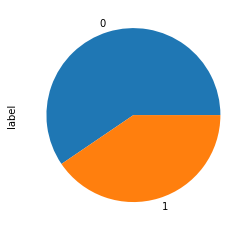

In [8]:
train_data['label'].value_counts().plot(kind='pie')

* The class distribution in the training dataset is _slightly_ uneven. 
* For now, I'll be skipping the steps to rebalance the dataset. But based on the results of the CNN, I might re-visit this decision.

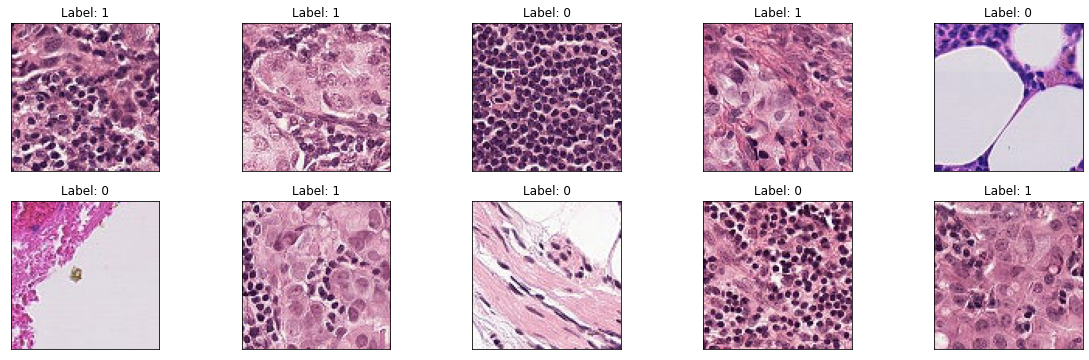

In [9]:
fig = plt.figure(figsize=(20, 6))

for idx, img in enumerate(np.random.choice(os.listdir(train_path), 10)):
    ax = fig.add_subplot(2, 10//2, idx+1, xticks=[], yticks=[])
    im = Image.open(f"{train_path}" + img)
    plt.imshow(im)
    lab = train_data.loc[train_data['id'] == img.split('.')[0], 'label'].values[0]
    ax.set_title(f'Label: {lab}')

* With a quick visual analysis, I can't distinctly differentiate the scans that have a tumor (label = 1) from those that don't. But then again, I am not a radiologist :) 
* It will be really interesting to see how a ML algorithm solves this challenge. 

## Analysis (Model building + training)

### Create the training & validation sets

In [10]:
train_df, valid_df = train_test_split(train_data, test_size=0.25, random_state=42, stratify=train_data.label)

train_df.shape, valid_df.shape

((165018, 2), (55007, 2))

In [11]:
train_df['id'] = train_df['id'] + '.tif'
valid_df['id'] = valid_df['id'] + '.tif'

In [12]:
# train_datagen below complains if the label values aren't string 
train_df['label'] = train_df['label'].astype(str)
valid_df['label'] = valid_df['label'].astype(str)

In [13]:
train_datagen=ImageDataGenerator(rescale=1/255)

train_generator=train_datagen.flow_from_dataframe(dataframe=train_df,directory=train_path,
                x_col="id",y_col="label",batch_size=64,seed=42,shuffle=True,
                class_mode="binary",target_size=(96,96))

valid_generator=train_datagen.flow_from_dataframe(dataframe=valid_df,directory=train_path,
                x_col="id",y_col="label",batch_size=64,seed=42,shuffle=True,
                class_mode="binary",target_size=(96,96))

Found 165018 validated image filenames belonging to 2 classes.
Found 55007 validated image filenames belonging to 2 classes.


### Create the baseline model

In [14]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',input_shape=(96,96,3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
          
model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(512))
model.add(Activation('relu'))

model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))
opt = tf.keras.optimizers.Adam(0.001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

2022-09-27 15:30:14.810937: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-27 15:30:14.901481: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-27 15:30:14.902304: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-27 15:30:14.904137: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 96, 96, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 94, 94, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 94, 94, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 45, 45, 64)        0

In [16]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

history = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=20, verbose=1
)

2022-09-27 15:30:32.365009: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-09-27 15:30:34.380379: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


2578/2578 [==============================] - 1431s 552ms/step - loss: 0.4324 - accuracy: 0.8020 - val_loss: 0.3249 - val_accuracy: 0.8631
Epoch 2/20
2578/2578 [==============================] - 421s 163ms/step - loss: 0.3131 - accuracy: 0.8685 - val_loss: 0.2925 - val_accuracy: 0.8767
Epoch 3/20
2578/2578 [==============================] - 297s 115ms/step - loss: 0.2693 - accuracy: 0.8913 - val_loss: 0.2617 - val_accuracy: 0.8896
Epoch 4/20
2578/2578 [==============================] - 291s 113ms/step - loss: 0.2458 - accuracy: 0.9018 - val_loss: 0.2943 - val_accuracy: 0.8777
Epoch 5/20
2578/2578 [==============================] - 289s 112ms/step - loss: 0.2409 - accuracy: 0.9047 - val_loss: 0.2293 - val_accuracy: 0.9118
Epoch 6/20
2578/2578 [==============================] - 311s 121ms/step - loss: 0.2234 - accuracy: 0.9124 - val_loss: 0.2080 - val_accuracy: 0.9197
Epoch 7/20
2578/2578 [==============================] - 295s 114ms/step - loss: 0.2073 - accuracy: 0.9203 - val_loss: 0.20

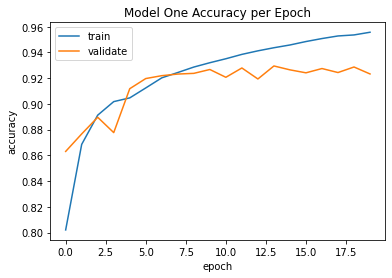

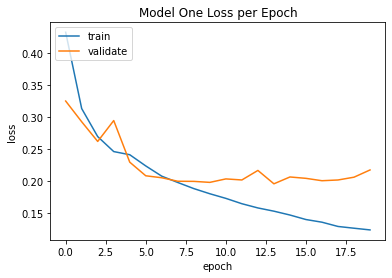

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model One Accuracy per Epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

# plot model loss per epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model One Loss per Epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

In [30]:
model2 = Sequential()

model2.add(Conv2D(32, (3, 3), padding='same',input_shape=(96,96,3)))
model2.add(Activation('relu'))
model2.add(Conv2D(32, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(BatchNormalization())

model2.add(Conv2D(64, (3, 3)))
model2.add(Activation('relu'))
model2.add(Conv2D(64, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(BatchNormalization())

model2.add(Conv2D(128, (3, 3)))
model2.add(Activation('relu'))
model2.add(Conv2D(128, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(BatchNormalization())

model2.add(Conv2D(256, (3, 3)))
model2.add(Activation('relu'))
model2.add(Conv2D(256, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(BatchNormalization())
          
model2.add(Flatten())

model2.add(Dense(1, activation='sigmoid'))
opt = tf.keras.optimizers.Adam(0.001)
model2.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [32]:
model2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 96, 96, 32)        896       
_________________________________________________________________
activation_46 (Activation)   (None, 96, 96, 32)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 94, 94, 32)        9248      
_________________________________________________________________
activation_47 (Activation)   (None, 94, 94, 32)        0         
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 47, 47, 32)        0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 47, 47, 32)        128       
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 45, 45, 64)       

In [40]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [early_stop, reduce_lr]

In [41]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

history2 = model2.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=20, verbose=1, callbacks=callbacks_list
)

Epoch 1/20
2578/2578 [==============================] - 293s 114ms/step - loss: 0.0169 - accuracy: 0.9942 - val_loss: 0.2863 - val_accuracy: 0.9382
Epoch 2/20
2578/2578 [==============================] - 297s 115ms/step - loss: 0.0166 - accuracy: 0.9941 - val_loss: 0.3608 - val_accuracy: 0.9233
Epoch 3/20
2578/2578 [==============================] - 294s 114ms/step - loss: 0.0156 - accuracy: 0.9945 - val_loss: 0.3779 - val_accuracy: 0.9318
Epoch 4/20
2578/2578 [==============================] - 310s 120ms/step - loss: 0.0152 - accuracy: 0.9947 - val_loss: 0.4488 - val_accuracy: 0.9122


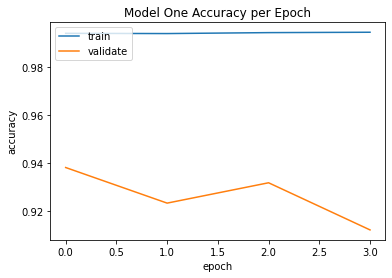

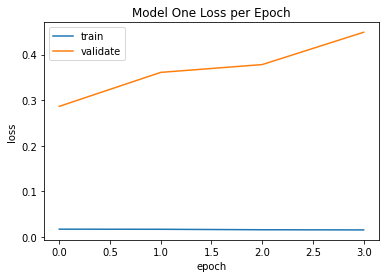

In [42]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model One Accuracy per Epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

# plot model loss per epoch
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model One Loss per Epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();